In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import tensorflow as tf
print('TF Version: ' + str(tf.__version__))
physical_devices = tf.config.list_physical_devices('GPU')
print('GPUs: ' + str(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

TF Version: 2.8.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.learning import training
from src.model import BIC
from src.parsing import load_dataset
from src.parsing import preprocess
from src.parsing import instantiate_radial_vectors
import tensorflow_addons as tfa
import copy
import matplotlib

### Parameter Setup
The `img_id` and `angle_id` specify the image and its rotation angle for which the similarity matrix should be plotted.
Keep in mind that the parameters need to fit the pre-trained model.

In [3]:
n_beams = 16
dataset_name = 'coil100'
target_size = 128
model_path = './model/coil100.h5py'
margin_padding = math.ceil(target_size * (math.sqrt(2) - 1))
img_id = 51
angle_id = 5

In [4]:
# load the target dataset
dataset = load_dataset(dataset_name, partial=None)

# find the target image
for d, data in enumerate(dataset):
    image = tf.cast(data['image'], tf.float32) / 255.
    if d == img_id:
        break

# radial beam sampling
lines, angels = instantiate_radial_vectors(target_size + margin_padding, target_size + margin_padding,
                                           beam_set_size=n_beams,
                                           max_len=target_size // 2)

# zero pad the image by the min margin
image = tf.pad(image, [
    [tf.math.maximum(0, (target_size + margin_padding - image.shape[1]) // 2),
     tf.math.maximum(0, (target_size + margin_padding - image.shape[1]) // 2)],
    [tf.math.maximum(0, (target_size + margin_padding - image.shape[0]) // 2),
     tf.math.maximum(0, (target_size + margin_padding - image.shape[0]) // 2)],
    [0, 0]], "CONSTANT")

# rotate image and evaluate beams
angels = (np.array(angels) / 180) * math.pi
images = [tfa.image.rotate(image, angle, interpolation='bilinear') for angle in angels]
beams = np.array([tf.gather_nd(i, lines) for i in images])
n_beams, _, n_pixels, n_channels = beams[0].shape

2022-05-20 16:44:51.285772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 16:44:51.785017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43672 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:43:00.0, compute capability: 8.6
2022-05-20 16:44:51.930310: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().rep

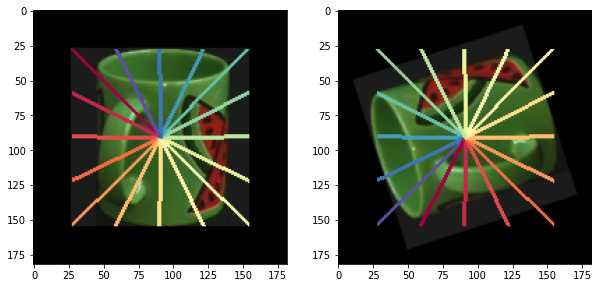

In [5]:
def img_color_beams(ax, image, lines, colors):
    image = np.array(image)
    for line, color in zip(lines, colors[:, :3] / 255):
        image[line[1, :, 0], line[1, :, 1]] = color
        image[line[0, :, 0], line[0, :, 1]] = color
        image[line[2, :, 0], line[2, :, 1]] = color
    ax.imshow(image)
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

# unique color codes for each beam
color_codes = np.array([matplotlib.cm.get_cmap('Spectral')(i, bytes=True)
                        for i in np.linspace(0, 1, n_beams)])

# circle color codes by rotation angle
colors = np.array([np.roll(color_codes, i, axis=0) for i in range(len(angels))])

# plot X_0 and X_theta with color beams as a sanity check
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = img_color_beams(ax[0], images[0], lines, colors[0])
ax[1] = img_color_beams(ax[1], images[angle_id], lines, colors[angle_id])
plt.show()

In [6]:
# input tensor (batch x (zero, theta) x beams x (2epsilon + 1) x D x C)
in_beams = tf.keras.layers.Input([2, n_beams, 3, n_pixels, n_channels])

bic = BIC(hidden=128, activation=tf.nn.leaky_relu, context=True,
          l2_regularization=0.0, edge_factor=0.5, gcn_layers=3, dropout=0.0,
          size_vector_field=n_beams, pixel_count_per_vector=n_pixels)

# multiple output for introspection; for training and inference: prior and unit_vec are essential
prior, unit_vec, beamencoding, ctx, similarity, \
beamencoding_zero, beamencoding_theta, angle_energy, rnn_encoding = bic(inputs=in_beams)

model = tf.keras.models.Model(inputs=in_beams, name='bic',
                              outputs=(prior, unit_vec, beamencoding, ctx, similarity, \
                                       beamencoding_zero, beamencoding_theta, angle_energy, rnn_encoding))

model = tf.keras.models.load_model(model_path)

model.summary()

Model: "bic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 beams (InputLayer)          [(None, 2, 16, 3, 64, 3)  0         
                             ]                                   
                                                                 
 bic (BIC)                   ((None, 16),              560226    
                              (None, 2),                         
                              (None, 2, 16, 128),                
                              (None, 2, 128),                    
                              (None, 16, 16),                    
                              (None, 16, 128),                   
                              (None, 16, 128),                   
                              (None, 16, 16),                    
                              (None, 128))                       
                                                               

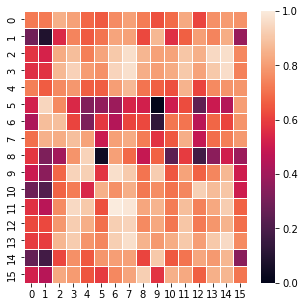

In [9]:
plt.figure(figsize=(5, 5))

_input = tf.cast([tf.concat([beams[0][None], beam[None]], axis=0) for beam in beams], tf.float32)
prior, unit_vec, beamencoding, ctx, similarity, \
beamencoding_zero, beamencoding_theta, angle_energy, rnn_encoding = bic(_input)

similarity = (similarity[angle_id] - tf.reduce_min(similarity[angle_id])) / \
             (tf.reduce_max(similarity[angle_id]) - tf.reduce_min(similarity[angle_id]))
sns.heatmap(similarity, linewidths=.5, cbar=True)
plt.show()